## 🚨 CrisisResponse: Disaster Message Classification Pipeline

**Author:** Hottam Ud Din  
**Objective:** To build a Natural Language Processing (NLP) pipeline that categorizes real-time disaster messages into 36 humanitarian clusters (e.g., Water, Medical, Shelter).

### 📝 Project Overview
In this notebook, we will:
1. **Load & Clean** raw text data from real disaster events.
2. **Preprocess** text using NLTK (Tokenization & Lemmatization).
3. **Train** a Multi-Output Random Forest Classifier.
4. **Evaluate** the model's ability to identify critical needs.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Download necessary NLTK data for text processing
nltk.download(['punkt', 'wordnet', 'stopwords', 'omw-1.4'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Visualization styling
sns.set(style="whitegrid")
print("Libraries Imported Successfully!")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


Libraries Imported Successfully!


## 2. Load Data
We load the two separate datasets: `messages.csv` contains the text, and `categories.csv` contains the labels.

In [2]:
# Load datasets from Kaggle input directory
messages = pd.read_csv('/kaggle/input/disaster-response-messages/disaster_messages.csv')
categories = pd.read_csv('/kaggle/input/disaster-response-messages/disaster_categories.csv')

print("Messages shape:", messages.shape)
print("Categories shape:", categories.shape)

Messages shape: (26248, 4)
Categories shape: (26248, 2)


## 3. Data Merging
Since the data is split into two files, we merge them using the common `id` column to ensure every message matches its correct tags.

In [3]:
# Merge the two dataframes on the common 'id' column
df = pd.merge(messages, categories, on='id')

# Display the first row to see the messy 'categories' column
df.head(2)

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...


## 4. Data Cleaning (Splitting Categories)
The `categories` column is currently a long string (e.g., `related-1;request-0...`). We need to split this string into 36 separate columns.

In [4]:
# Create a dataframe of the 36 individual category columns
categories_split = df['categories'].str.split(';', expand=True)

# Select the first row of the categories dataframe to extract column names
row = categories_split.iloc[0]

# Apply a lambda function that takes everything up to the second to last character of each string with slicing
category_colnames = row.apply(lambda x: x[:-2])

# Rename the columns of `categories`
categories_split.columns = category_colnames

print(categories_split.columns)
categories_split.head()

Index(['related', 'request', 'offer', 'aid_related', 'medical_help',
       'medical_products', 'search_and_rescue', 'security', 'military',
       'child_alone', 'water', 'food', 'shelter', 'clothing', 'money',
       'missing_people', 'refugees', 'death', 'other_aid',
       'infrastructure_related', 'transport', 'buildings', 'electricity',
       'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure',
       'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold',
       'other_weather', 'direct_report'],
      dtype='object', name=0)


,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


## 4.1 Data Cleaning (Converting to Binary)
Now that we have columns, we need to convert the values (like `related-1`) into simple numbers (`1` or `0`).

In [5]:
for column in categories_split:
    # Set each value to be the last character of the string
    categories_split[column] = categories_split[column].astype(str).str[-1]
    
    # Convert column from string to numeric
    categories_split[column] = pd.to_numeric(categories_split[column])
    
    # Ensure values are binary (0 or 1). Some datasets have typos with '2'.
    categories_split[column] = categories_split[column].apply(lambda x: 1 if x >= 1 else 0)

print("Categories converted to binary!")

Categories converted to binary!


## 5. Finalizing the Dataset
We replace the old messy `categories` column in our main dataframe with the new clean columns and drop any duplicates.

In [6]:
# Drop the original categories column from `df`
df.drop('categories', axis=1, inplace=True)

# Concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df, categories_split], axis=1)

# Drop duplicates
df.drop_duplicates(inplace=True)

print("Final Data Shape:", df.shape)
df.head()

Final Data Shape: (26215, 40)


,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6. Exploratory Data Analysis (EDA)
Before training, we must visualize the data imbalance. This shows us which categories (like "Water") are rare and hard to predict.

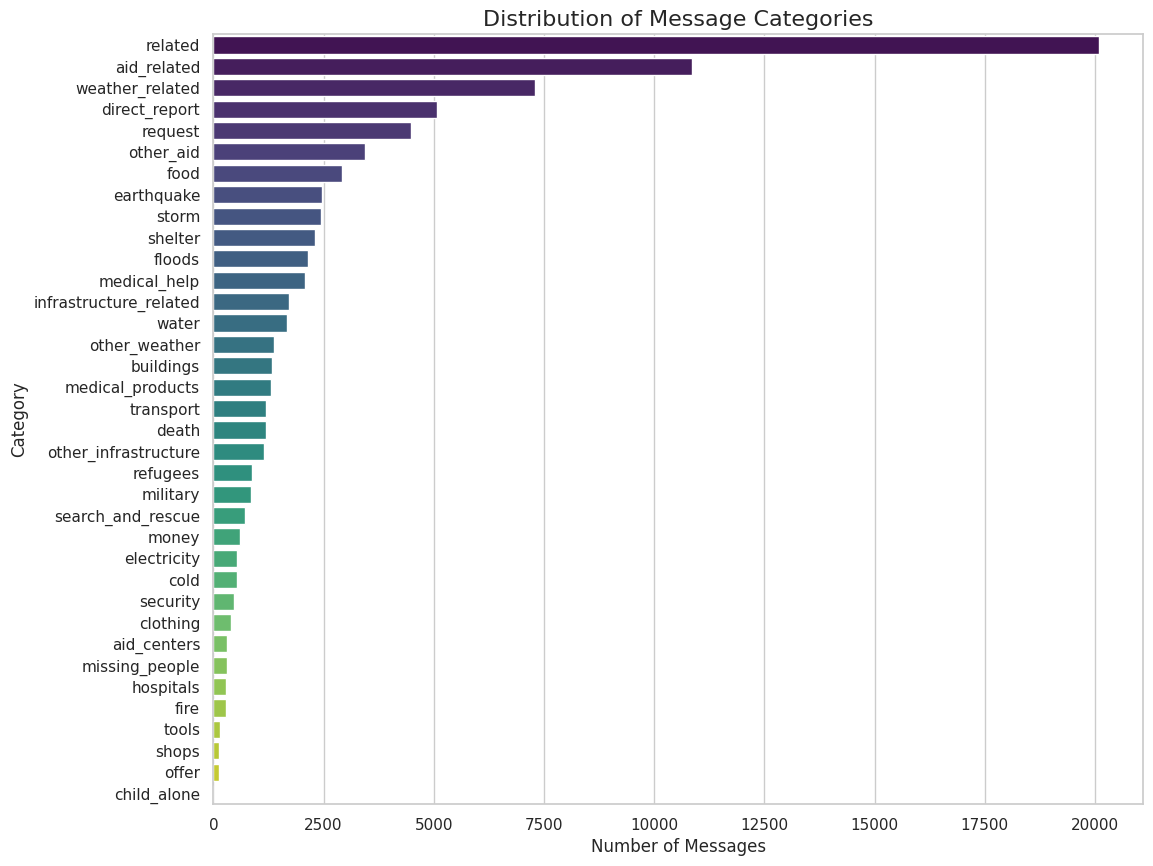

In [7]:
# Calculate the count of each category
category_counts = df.iloc[:, 4:].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 10))
sns.barplot(x=category_counts.values, y=category_counts.index, palette="viridis")
plt.title("Distribution of Message Categories", fontsize=16)
plt.xlabel("Number of Messages")
plt.ylabel("Category")
plt.show()

## 7. Text Preprocessing
Machines cannot read text. We define a function `tokenize` that converts raw sentences into clean lists of words (tokens) by removing punctuation, converting to lowercase, and lemmatizing (turning "running" into "run").

In [8]:
def tokenize(text):
    """
    Normalizes, tokenizes, and lemmatizes text string.
    """
    # Normalize text (remove punctuation and lowercase)
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove Stopwords and Lemmatize
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    
    clean_tokens = []
    for tok in tokens:
        if tok not in stop_words:
            clean_tok = lemmatizer.lemmatize(tok).strip()
            clean_tokens.append(clean_tok)

    return clean_tokens

# Test the function
print(tokenize("Flooding in Peshawar! We need urgent medical supplies."))

['flooding', 'peshawar', 'need', 'urgent', 'medical', 'supply']


## 8. Building the ML Pipeline
We use a Scikit-Learn Pipeline to bundle our steps. This ensures that every message goes through the exact same process (Vectorization -> TF-IDF -> Classification).

Note: We use `MultiOutputClassifier` because one message can have multiple tags (e.g., Water AND Food).

In [9]:
# 1. Split data into Training and Test sets
X = df['message']
Y = df.iloc[:, 4:] # Select all category columns
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 2. Build Pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize, max_features=5000)), # Keep top 5000 words
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=42)))
])

# 3. Train Pipeline
print("Training model...")
pipeline.fit(X_train, Y_train)
print("Training Complete!")

Training model...


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Training Complete!


## 9. Model Evaluation
We use the `classification_report` to check Precision, Recall, and F1-Score. This is crucial for verifying if the model works on rare classes.

In [10]:
y_pred = pipeline.predict(X_test)

# Convert predictions to DataFrame for readability
y_pred_df = pd.DataFrame(y_pred, columns=Y.columns)
y_test_df = pd.DataFrame(Y_test, columns=Y.columns)

# Check performance on a few critical categories
target_cols = ['medical_help', 'water', 'shelter', 'food', 'search_and_rescue']

print("-" * 60)
print("PERFORMANCE REPORT (Critical Categories)")
print("-" * 60)

for col in target_cols:
    print(f"Category: {col.upper()}")
    print(classification_report(y_test_df[col], y_pred_df[col]))
    print("-" * 40)

------------------------------------------------------------
PERFORMANCE REPORT (Critical Categories)
------------------------------------------------------------
Category: MEDICAL_HELP
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4808
           1       0.63      0.14      0.23       435

    accuracy                           0.92      5243
   macro avg       0.78      0.57      0.60      5243
weighted avg       0.90      0.92      0.90      5243

----------------------------------------
Category: WATER
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4908
           1       0.85      0.41      0.55       335

    accuracy                           0.96      5243
   macro avg       0.90      0.70      0.77      5243
weighted avg       0.95      0.96      0.95      5243

----------------------------------------
Category: SHELTER
              precision    recall  f1-score 

## 10. Real World Testing
Finally, we create a function to simulate how this model would be used in the field. We feed it custom sentences to see how it tags them.

In [11]:
def predict_message(message):
    # Predict
    prediction = pipeline.predict([message])[0]
    
    # Map results to category names
    results = dict(zip(Y.columns, prediction))
    
    # Filter only positive tags
    detected_tags = [k for k, v in results.items() if v == 1]
    
    print(f"Message: '{message}'")
    print(f"Detected Tags: {detected_tags}")
    print("-" * 50)

# Test with custom strings
predict_message("We are stuck in Swat valley with no food and dirty water.")
predict_message("Is the hurricane over? When can we go back home?")
predict_message("Need a helicopter for rescue in Mingora.")

Message: 'We are stuck in Swat valley with no food and dirty water.'
Detected Tags: ['related', 'aid_related', 'food']
--------------------------------------------------
Message: 'Is the hurricane over? When can we go back home?'
Detected Tags: ['related', 'weather_related', 'storm']
--------------------------------------------------
Message: 'Need a helicopter for rescue in Mingora.'
Detected Tags: ['related', 'aid_related', 'search_and_rescue']
--------------------------------------------------
